In [98]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import zipfile
import cv2
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [99]:
def zip_fun (zip_file_path,extract_to_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # List files in the ZIP
        print("Files in the ZIP:", zip_ref.namelist())

        # Extract all files
        zip_ref.extractall(extract_to_path)
        print(f"Files extracted to {extract_to_path}")

    return extract_to_path

In [100]:
# Define paths
train = "C:/Users/rolar/Downloads/projects_cv/dataset/training_set"
test = "C:/Users/rolar/Downloads/projects_cv/dataset/test_set"


In [101]:
# Image parameters
img_size = 128
batch_size = 32

In [102]:
# Function to load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_size, img_size))
        img_array = img_to_array(img) / 255.0  # Normalize images
        images.append(img_array)
        labels.append(label)
    return images, labels

In [103]:

# Load training images for both classes
cat_motion_blur, cat_motion_blur_labels = load_images_from_folder(os.path.join(train, 'cats/motion_blur'), label=0)
dog_motion_blur, dog_motion_blur_labels = load_images_from_folder(os.path.join(train, 'dogs/motion_blur'), label=1)


cat_selt,cat_selt_labels=load_images_from_folder(os.path.join(train, 'cats/salt_and_pepper_noise'), label=0)
dog_selt,dog_selt_labels=load_images_from_folder(os.path.join(train, 'dogs/salt_and_pepper_noise'), label=1)



In [113]:
# Load test images for both classes
cat_test_images_blur, cat_test_labels_blur = load_images_from_folder(os.path.join(test, 'cats/motion_blur'), label=0)
dog_test_images_blur, dog_test_labels_blur = load_images_from_folder(os.path.join(test, 'dogs/motion_blur'), label=1)

cat_test_images_saltPaper, cat_test_labels_saltPaper = load_images_from_folder(os.path.join(test, 'cats/salt_and_pepper_noise'), label=0)
dog_test_images_saltPaper, dog_test_labels_saltPaper = load_images_from_folder(os.path.join(test, 'dogs/salt_and_pepper_noise'), label=1)


In [15]:
"""**motion blure data**"""

x_train_motin=np.concatenate((cat_motion_blur,dog_motion_blur),axis=0)
y_train_motin=np.concatenate((cat_motion_blur_labels,dog_motion_blur_labels),axis=0)

X_test_motin=np.concatenate((cat_test_images_blur,dog_test_images_blur),axis=0)
y_test_motin=np.concatenate((cat_test_labels_blur,dog_test_labels_blur),axis=0)

"""**salt and paper data**"""

X_train_salt=np.concatenate((cat_selt,dog_selt),axis=0)
y_train_salt=np.concatenate((cat_selt_labels,dog_selt_labels),axis=0)

X_test_salt=np.concatenate((cat_test_images_saltPaper,dog_test_images_saltPaper),axis=0)
y_test_salt=np.concatenate((cat_test_labels_saltPaper,dog_test_labels_saltPaper),axis=0)


**motion blure**

In [16]:

def last_Apply_Motion_Blur1(image, kernel_size=3):

    # Split the Image into Channels
    b, g, r = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    sigma = kernel_size/2

    # Create a Gaussian kernel
    gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)

    # Create a motion blur kernel by outer product for horizontal blur
    motion_blur_kernel = np.dot(gaussian_kernel, gaussian_kernel.T)

    # Normalize the kernel
    kernel = motion_blur_kernel / motion_blur_kernel.sum()

    # Apply motion blur filter to each channel
    filtered_blue = cv2.filter2D(b, -1, kernel)
    filtered_green = cv2.filter2D(g, -1, kernel)
    filtered_red = cv2.filter2D(r, -1, kernel)


    # Clip the values to ensure they are in the range [0, 255]
    blue_channel_adjusted = np.clip(filtered_blue, 0, 255)
    green_channel_adjusted = np.clip(filtered_green, 0, 255)
    red_channel_adjusted = np.clip(filtered_red, 0, 255)


    # Merge the channels back together
    filtered_image = cv2.merge((blue_channel_adjusted, green_channel_adjusted, red_channel_adjusted))

    # Define a sharpening kernel with adjusted intensity
    sharpening_kernel = np.array([
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]
      ])

    # Apply sharpening
    sharpened_image = cv2.filter2D(filtered_image, -1, sharpening_kernel)

    sharpened_image = np.clip(sharpened_image, 0, 255)

    return sharpened_image

In [17]:

x_train_motion_processed = []
for img in x_train_motin:
    processed_img = last_Apply_Motion_Blur1(img)
    x_train_motion_processed.append(processed_img)

x_train_motion_processed = np.array(x_train_motion_processed)

x_test_motion_processed = []
for img in X_test_motin:
    processed_img = last_Apply_Motion_Blur1(img)
    x_test_motion_processed.append(processed_img)

x_test_motion_processed = np.array(x_test_motion_processed)


In [18]:

# Find indexes for the first few images of each class
cat_indexes = np.where(y_train_motin == 0)[0][:5]  # First 5 cat images
dog_indexes = np.where(y_train_motin == 1)[0][:4]  # First 4 dog images

# Combine indexes to get a mix of cat and dog images
sample_indexes1 = np.concatenate([cat_indexes, dog_indexes])

for i, idx in enumerate(sample_indexes1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train_motion_processed[idx])
    plt.title("Cat" if y_train_motin[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()



**motion blure from scratch**

In [ ]:
def motion_blur_scratch(image,kernel_size=3):
    
    # Split image into channels
    b, g, r = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    sigma = kernel_size / 2.0
    
    gaussian_kernel_1d = np.array([
        (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - kernel_size // 2)  2 / (2 * sigma  2))
        for x in range(kernel_size)
    ])
    
    gaussian_kernel_1d /= np.sum(gaussian_kernel_1d)  # Normalize the kernel

    # Create a 2D Gaussian kernel by outer product
    motion_blur_kernel = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    motion_blur_kernel /= np.sum(motion_blur_kernel)  # Normalize

    
    # Step 2: Implement convolution manually
    def convolve(channel, kernel):
        h, w = channel.shape
        k_h, k_w = kernel.shape
        pad_h, pad_w = k_h // 2, k_w // 2

        # Pad the image
        padded_channel = np.pad(channel, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

        # Create an output array
        convolved = np.zeros_like(channel, dtype=np.float32)

        # Perform convolution
        for i in range(h):
            for j in range(w):
                region = padded_channel[i:i + k_h, j:j + k_w]
                convolved[i, j] = np.sum(region * kernel)

        return convolved


    # Apply motion blur convolution to each channel
    filtered_blue = convolve(b, motion_blur_kernel)
    filtered_green = convolve(g, motion_blur_kernel)
    filtered_red = convolve(r, motion_blur_kernel)

    # Clip the values to ensure they are within [0, 255]
    filtered_blue = np.clip(filtered_blue, 0, 255)
    filtered_green = np.clip(filtered_green, 0, 255)
    filtered_red = np.clip(filtered_red, 0, 255)

    # Merge the channels back together
    filtered_image = np.stack((filtered_blue, filtered_green, filtered_red), axis=2)

    # Step 3: Create a sharpening kernel manually
    sharpening_kernel = np.array([
        [-1, -1, -1],
        [-1, 9, -1],
        [-1, -1, -1]
    ])

    sharpened_blue = convolve(filtered_blue, sharpening_kernel)
    sharpened_green = convolve(filtered_green, sharpening_kernel)
    sharpened_red = convolve(filtered_red, sharpening_kernel)

    # Clip the values to ensure they are within [0, 255]
    sharpened_blue = np.clip(sharpened_blue, 0, 255)
    sharpened_green = np.clip(sharpened_green, 0, 255)
    sharpened_red = np.clip(sharpened_red, 0, 255)

    # Merge the channels back together to form the final image
    sharpened_image = np.stack((sharpened_blue, sharpened_green, sharpened_red), axis=2)

    
  
    return sharpened_image

In [ ]:
x_train_motion_scratch = []
for img in x_train_motin[:9]:
    processed_img = motion_blur_scratch(img)
    x_train_motion_scratch.append(processed_img)

x_train_motion_scratch = np.array(x_train_motion_scratch)


for i, idx in enumerate(range(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train_motion_scratch[idx])
    plt.title("Cat" if y_train_motin[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()

**salt and paper**

In [105]:
def apply_filters(images):
    filtered_images = []
    for img in images:
        # Median filter (applied multiple times for stronger effect)
        for _ in range(17):  # Limit repetitions for efficiency
            img = cv2.medianBlur(img, 3)

        # Gaussian filter
        for _ in range(2):  # Reduce repetitions for better processing speed
            img = cv2.GaussianBlur(img, (7, 7), 0)


        # Max kernel filter
        kernel = np.ones((5, 5), np.uint8)
        img = cv2.dilate(img, kernel)  # Max filter via dilation
        # Min kernel filter
        img = cv2.erode(img, kernel)  # Min filter via erosion

        # Append the processed image
        filtered_images.append(img)

    return np.array(filtered_images)

# Apply filters to training and test sets
x_fix = apply_filters(X_train_salt)
x_test_salt_processed = apply_filters(X_test_salt)



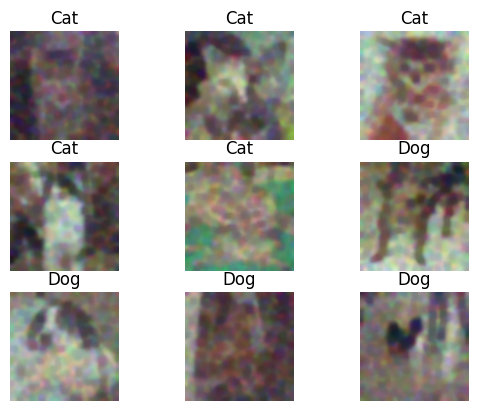

In [106]:
# Find indexes for the first few images of each class
cat_indexes = np.where(y_train_salt == 0)[0][:5]  # First 5 cat images
dog_indexes = np.where(y_train_salt == 1)[0][:4]  # First 4 dog images

# Combine indexes to get a mix of cat and dog images
sample_indexes2 = np.concatenate([cat_indexes, dog_indexes])

for i, idx in enumerate(sample_indexes2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_fix[idx])
    plt.title("Cat" if y_train_salt[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()


**salt and paper noise scratch**

In [ ]:
def apply_filters_scratch(images):
    
    def median_filter(image, kernel_size):
        """Apply a median filter to the image."""
        pad_size = kernel_size // 2
        padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
        filtered_image = np.zeros_like(image)
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for k in range(image.shape[2]):  # Process each channel
                    region = padded_image[i:i+kernel_size, j:j+kernel_size, k]
                    filtered_image[i, j, k] = np.median(region)
        return filtered_image

    def gaussian_filter(image, kernel_size, sigma):
        """Apply a Gaussian filter to the image."""
        pad_size = kernel_size // 2
        padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
        filtered_image = np.zeros_like(image)
        
        # Create Gaussian kernel
        ax = np.linspace(-(kernel_size - 1) // 2, (kernel_size - 1) // 2, kernel_size)
        gaussian = np.exp(-0.5 * (ax / sigma)**2)
        gaussian_kernel = np.outer(gaussian, gaussian)
        gaussian_kernel /= gaussian_kernel.sum()
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for k in range(image.shape[2]):  # Process each channel
                    region = padded_image[i:i+kernel_size, j:j+kernel_size, k]
                    filtered_image[i, j, k] = np.sum(region * gaussian_kernel)
        return filtered_image

    def max_filter(image, kernel_size):
        """Apply a max filter to the image."""
        pad_size = kernel_size // 2
        padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
        filtered_image = np.zeros_like(image)
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for k in range(image.shape[2]):  # Process each channel
                    region = padded_image[i:i+kernel_size, j:j+kernel_size, k]
                    filtered_image[i, j, k] = np.max(region)
        return filtered_image

    def min_filter(image, kernel_size):
        """Apply a min filter to the image."""
        pad_size = kernel_size // 2
        padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
        filtered_image = np.zeros_like(image)
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for k in range(image.shape[2]):  # Process each channel
                    region = padded_image[i:i+kernel_size, j:j+kernel_size, k]
                    filtered_image[i, j, k] = np.min(region)
        return filtered_image

    # Apply filters to each image
    filtered_images = []
    for img in images:
        # Apply Median filter
        img = median_filter(img, kernel_size=5)
        # Apply Gaussian filter
        img = gaussian_filter(img, kernel_size=7, sigma=4)
        # Apply Max filter
        img = max_filter(img, kernel_size=5)
        # Apply Min filter
        img = min_filter(img, kernel_size=5)
        filtered_images.append(img)
    
    return np.array(filtered_images)

In [ ]:
x_train_salt_scratch = apply_filters_scratch(X_train_salt[:9])

for i, idx in enumerate(range(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train_salt_scratch[idx])
    plt.title("Cat" if y_train_salt[idx] == 0 else "Dog")
    plt.axis("off")

plt.show()

**Concatenate data**


In [108]:

from sklearn.utils import shuffle

# Concatenate training data
X_train = np.concatenate((x_train_motion_processed, x_fix), axis=0)
y_train = np.concatenate((y_train_motin, y_train_salt), axis=0)

# Shuffle the training data and labels
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Concatenate validation data
x_val = np.concatenate((x_test_motion_processed, x_test_salt_processed), axis=0)
y_val = np.concatenate((y_test_motin, y_test_salt), axis=0)

# Shuffle the validation data and labels
x_val, y_val = shuffle(x_val, y_val, random_state=42)

# Check shapes and class distributions
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Class distribution in training set:", np.bincount(y_train))

print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("Class distribution in validation set:", np.bincount(y_val))

X_train shape: (16000, 128, 128, 3)
y_train shape: (16000,)
Class distribution in training set: [8000 8000]
x_val shape: (4000, 128, 128, 3)
y_val shape: (4000,)
Class distribution in validation set: [2000 2000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5162497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2258528].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0259297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1370287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0312142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011986658..1.2399753].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4298127].
Clipping input data to the

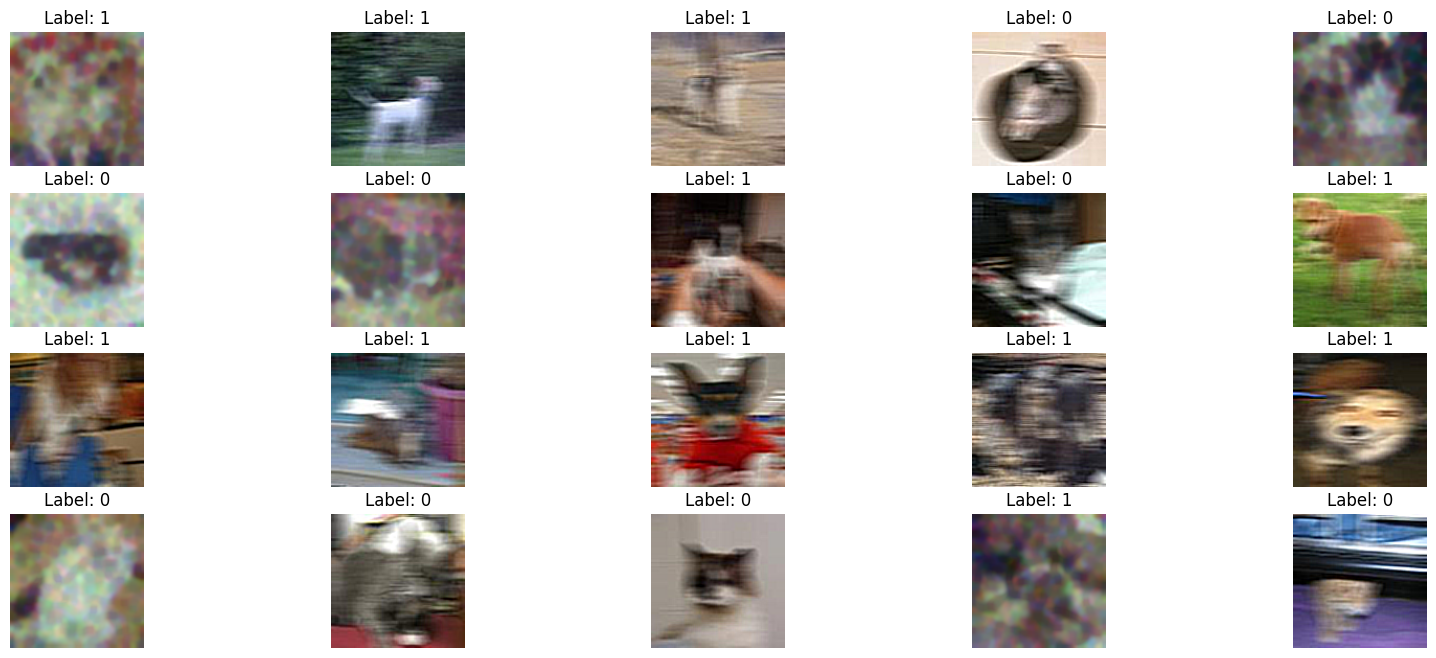

In [109]:
sample_indexes = np.random.choice(X_train.shape[0], 20)

# Create a 2x5 grid (10 images)
plt.figure(figsize=(20, 8))

# Display the images
for i, idx in enumerate(sample_indexes):
    plt.subplot(4, 5, i + 1)  # Create a 2x5 grid (2 rows, 5 columns)
    plt.imshow(X_train[idx])  # Show the image at the selected index
    plt.title(f"Label: {y_train[idx]}")  # Show the corresponding label
    plt.axis("off")

plt.show()


**Model**

In [110]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2



# Define the model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3), padding='same'),
    Conv2D(20, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.02), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.02), padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    # Use Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    #Dropout(0.5),  # Dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification
])



In [111]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 128, 128, 20)   │         2,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 64, 64, 32)     │         5,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,152,709 (4.40 MB)

 Trainable params: 1,151,773 (4.39 MB)

 Non-trainable params: 936 (3.66 KB)

In [112]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
callbacks = [early_stopping, reduce_lr]
model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])


In [92]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=callbacks, verbose=2
)




Epoch 1/40
500/500 - 385s - 769ms/step - accuracy: 0.6264 - loss: 2.8427 - val_accuracy: 0.4990 - val_loss: 1.5027 - learning_rate: 2.0000e-04
Epoch 2/40
500/500 - 321s - 642ms/step - accuracy: 0.6842 - loss: 0.9438 - val_accuracy: 0.5878 - val_loss: 0.9118 - learning_rate: 2.0000e-04
Epoch 3/40
500/500 - 337s - 675ms/step - accuracy: 0.7282 - loss: 0.7399 - val_accuracy: 0.6963 - val_loss: 0.7467 - learning_rate: 2.0000e-04
Epoch 4/40
500/500 - 293s - 586ms/step - accuracy: 0.7521 - loss: 0.6656 - val_accuracy: 0.7297 - val_loss: 0.6852 - learning_rate: 2.0000e-04
Epoch 5/40
500/500 - 292s - 585ms/step - accuracy: 0.7659 - loss: 0.6198 - val_accuracy: 0.6945 - val_loss: 0.7173 - learning_rate: 2.0000e-04
Epoch 6/40
500/500 - 291s - 581ms/step - accuracy: 0.7842 - loss: 0.5821 - val_accuracy: 0.6870 - val_loss: 0.7183 - learning_rate: 2.0000e-04
Epoch 7/40
500/500 - 293s - 586ms/step - accuracy: 0.7944 - loss: 0.5618 - val_accuracy: 0.6990 - val_loss: 0.6897 - learning_rate: 2.0000e-04

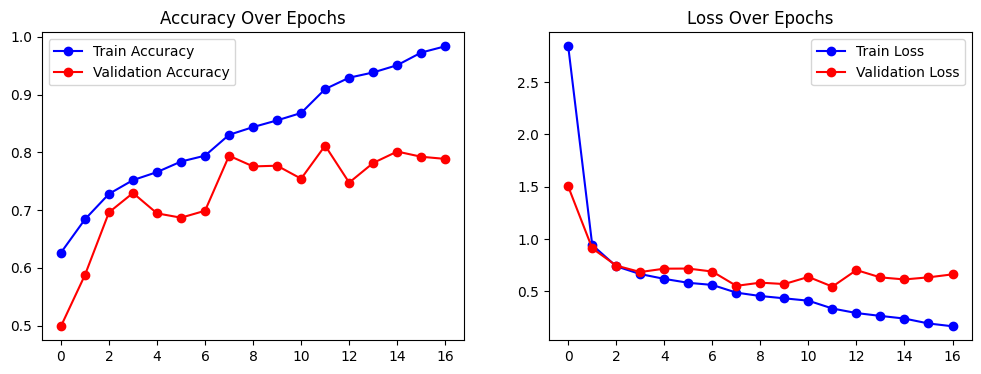

In [93]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'bo-', label='Train Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [94]:

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Accuracy: {accuracy:.4f}')
print(f'Loss: {loss:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.8149 - loss: 0.5453
Accuracy: 0.8117
Loss: 0.5456


125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step


<Figure size 1600x800 with 0 Axes>

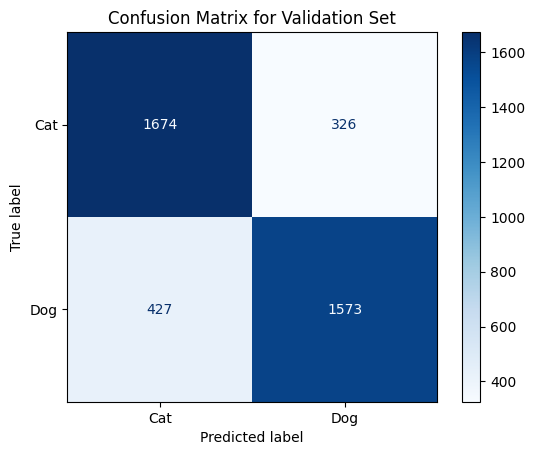

In [96]:

# Confusion Matrix
# Step 1: Make predictions on the validation set
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)
# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
# Display the confusion matrix
plt.figure(figsize=(16, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Validation Set")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1511672].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0688882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.032816].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3910863].


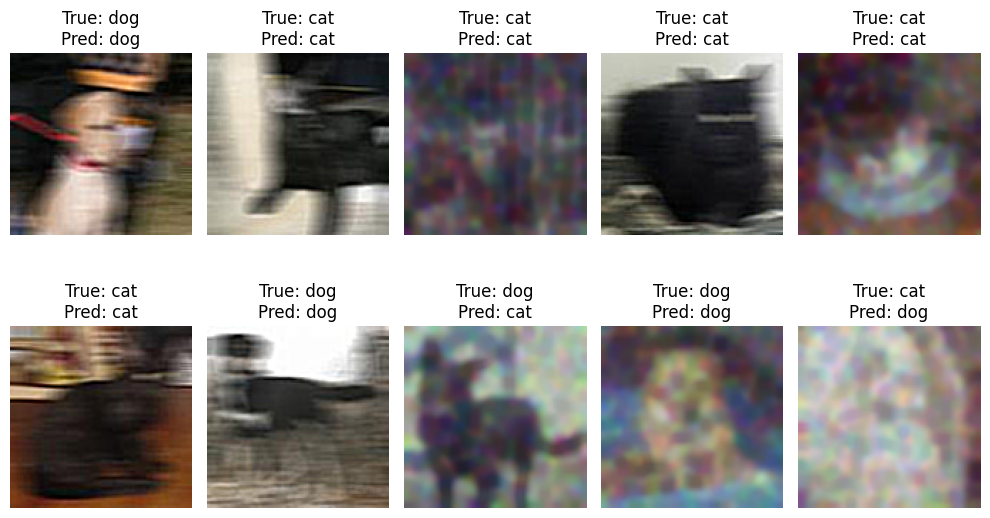

In [97]:

# Random Predictions
# Define the number of samples and rows
num_samples = 10  # Total number of samples to display
num_cols = 5  # Number of columns per row
num_rows = (num_samples + num_cols - 1) // num_cols  # Calculate required rows
# Select random indices from the test set
random_indices = np.random.choice(len(x_val), num_samples, replace=False)
# Plot the random predictions
plt.figure(figsize=(10, num_rows * 3))
for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(x_val[idx], cmap='gray')  # Display the image
    # Get true and predicted labels
    true_label = 'dog' if y_val[idx] == 1 else 'cat'  # True label
    pred_label = 'dog' if y_pred[idx][0] == 1 else 'cat'  # Predicted label
    # Title for true and predicted labels
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()